In [ ]:
!git clone https://github.com/saic-violet/bilayer-model.git

Cloning into 'bilayer-model'...
remote: Enumerating objects: 169, done.
remote: Total 169 (delta 0), reused 0 (delta 0), pack-reused 169
Receiving objects: 100% (169/169), 543.30 KiB | 13.93 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [ ]:
%cd /content/bilayer-model/

/content/bilayer-model


#Load face alignment and libraries

In [ ]:
!git clone https://github.com/1adrianb/face-alignment.git

fatal: destination path 'face-alignment' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.append('../')

import glob
import copy
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from infer import InferenceWrapper

# Load the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download Pretrained weights

- Download Pretrained model and put it in main directory

In [ ]:
!cp -r /content/drive/MyDrive/Bilayer /content/

In [ ]:
args_dict = {
    'project_dir': '../',
    'init_experiment_dir': '../runs/vc2-hq_adrianb_paper_main',
    'init_networks': 'identity_embedder, texture_generator, keypoints_embedder, inference_generator',
    'init_which_epoch': '2225',
    'num_gpus': 1,
    'experiment_name': 'vc2-hq_adrianb_paper_enhancer',
    'which_epoch': '1225',
    'spn_networks': 'identity_embedder, texture_generator, keypoints_embedder, inference_generator, texture_enhancer',
    'enh_apply_masks': False,
    'inf_apply_masks': False}

In [ ]:
module = InferenceWrapper(args_dict)

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip



Constructing DeepLabv3+ model...
Number of classes: 20
Output stride: 16
Number of Input Channels: 3
unexpected key "source_graph_2_fea.node_fea_for_res" in state_dict
unexpected key "source_graph_2_fea.node_fea_for_hidden" in state_dict
unexpected key "source_graph_2_fea.weight" in state_dict
unexpected key "source_skip_conv.0.weight" in state_dict
unexpected key "source_skip_conv.0.bias" in state_dict
unexpected key "source_semantic.weight" in state_dict
unexpected key "source_semantic.bias" in state_dict
unexpected key "middle_semantic.weight" in state_dict
unexpected key "middle_semantic.bias" in state_dict
unexpected key "middle_source_featuremap_2_graph.pre_fea" in state_dict
unexpected key "middle_source_featuremap_2_graph.weight" in state_dict
unexpected key "middle_source_graph_conv1.weight" in state_dict
unexpected key "middle_source_graph_conv2.weight" in state_dict
unexpected key "middle_source_graph_conv3.weight" in state_dict
unexpected key "middle_source_graph_2_fea.nod

# Download Video

In [ ]:
!gdown --id 18YLjerehlQNwIq7lUwIdsO9hS36zuY38

Downloading...
From: https://drive.google.com/uc?id=18YLjerehlQNwIq7lUwIdsO9hS36zuY38
To: /content/bilayer-model/Yomna_test.mp4
70.3MB [00:01, 65.8MB/s]


### Calculate poses, segmentation and do the inference

-1

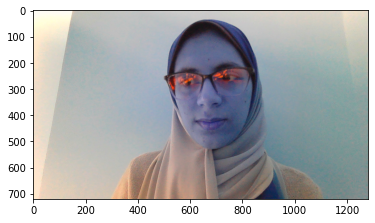

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

cap = cv2.VideoCapture('/content/bilayer-model/Yomna_test.mp4')
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

fc = 0
ret = True

while (fc < frameCount  and ret):
    ret, buf[fc] = cap.read()
    #buf[fc]=cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    fc += 1

cap.release()
plt.imshow(buf[0])

#cv2.namedWindow('frame 10')
#cv2.imshow('frame 10', buf[9])

cv2.waitKey(0)

In [ ]:
input_data_dict = {
    'source_imgs': np.asarray(Image.open('/content/Yomna_test_source_image_2.png')), # H x W x 3
    'target_imgs': np.asarray(buf[10])[None]} # B x H x W x # 3

output_data_dict = module(input_data_dict)

In [ ]:
def to_image(img_tensor, seg_tensor=None):
    img_array = ((img_tensor.clamp(-1, 1).cpu().numpy() + 1) / 2).transpose(1, 2, 0) * 255
    
    if seg_tensor is not None:
        seg_array = seg_tensor.cpu().numpy().transpose(1, 2, 0)
        img_array = img_array * seg_array + 255. * (1 - seg_array)

    return Image.fromarray(img_array.astype('uint8')), img_array.astype('uint8')

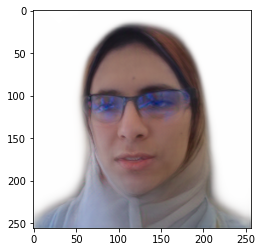

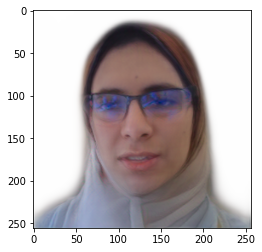

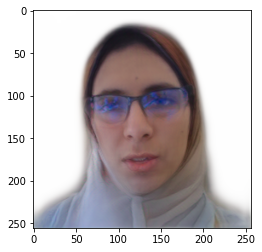

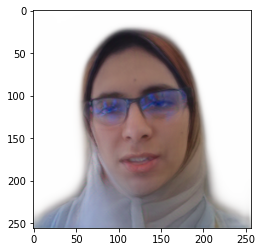

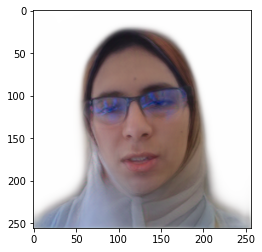

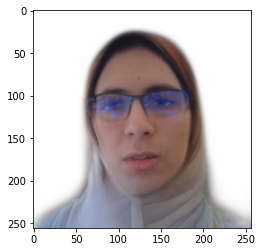

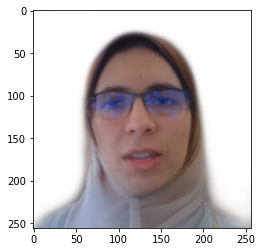

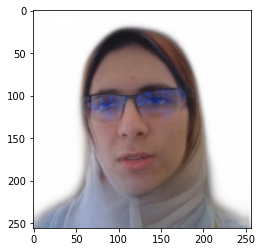

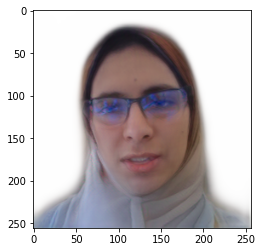

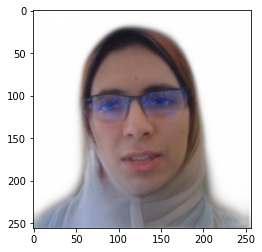

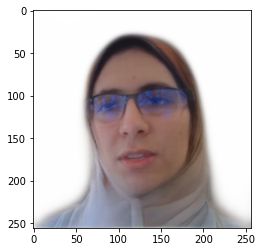

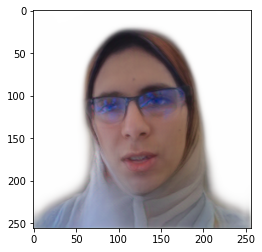

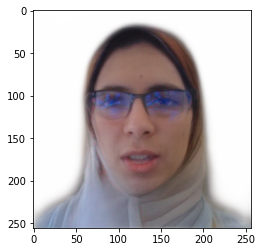

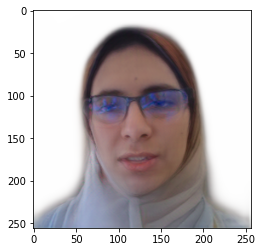

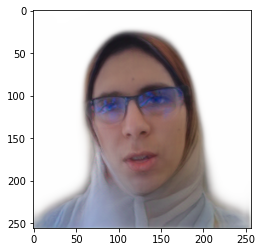

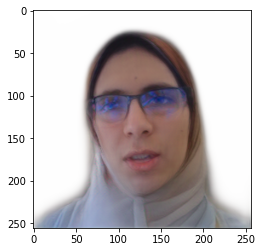

In [ ]:
video = []
for i in range(0,1600,100):
  input_data_dict = {
    'source_imgs': np.asarray(Image.open('/content/Yomna_test_source_image_2.png')), # H x W x 3
    'target_imgs': np.asarray(buf[i])[None]
    } # B x H x W x # 3
  output_data_dict = module(input_data_dict)
  source_img = to_image(output_data_dict['source_imgs'][0, 0])
  hf_texture = to_image(output_data_dict['pred_enh_tex_hf_rgbs'][0, 0])
  target_pose = to_image(output_data_dict['target_stickmen'][0, 0])
  pred_img, v= to_image(output_data_dict['pred_enh_target_imgs'][0, 0], output_data_dict['pred_target_segs'][0, 0])
  video.append(v)
  plt.imshow(pred_img)
  plt.show()

In [ ]:
video[0].shape

(256, 256, 3)

In [ ]:
source_image.shape

(256, 256, 3)

In [ ]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

source_image = imageio.imread('/content/received_49201136120601.jpeg')
source_image = resize(source_image, (256, 256))[..., :3]
def display(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
    

HTML(display(source_image.astype('uint8'), video).to_html5_video())

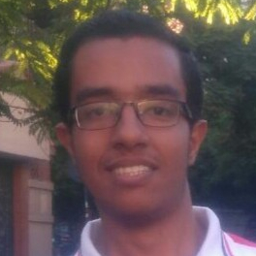

In [ ]:
source_img,_ = to_image(output_data_dict['source_imgs'][0, 0])
source_img

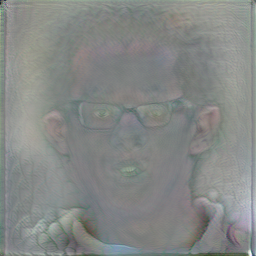

In [ ]:
hf_texture,_ = to_image(output_data_dict['pred_enh_tex_hf_rgbs'][0, 0])
hf_texture

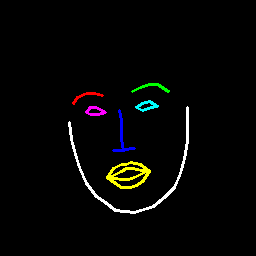

In [ ]:
target_pose,_ = to_image(output_data_dict['target_stickmen'][0, 0])
target_pose

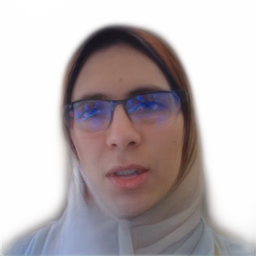

In [ ]:
pred_img,_ = to_image(output_data_dict['pred_enh_target_imgs'][0, 0], output_data_dict['pred_target_segs'][0, 0])
pred_img

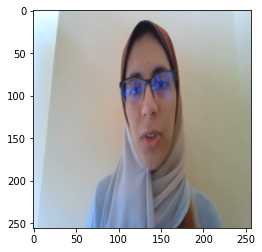

In [ ]:
source_image = imageio.imread('/content/Yomna_test_source_image_2.png')
source_image = resize(source_image, (256, 256))[..., :3]
plt.imshow(source_image)